Authored by Leon Garza & Omar Hoang

In [ ]:
!pip install datasets ragas seaborn openai matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.6/158.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.3/990.3 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [ ]:
from datasets import Dataset
from ragas import evaluate
import matplotlib.pyplot as plt
import os
from ragas.metrics import (
    answer_relevancy, # Metric for evaluating the relevancy of answers
    answer_correctness # Gauging the accuracy of the generated answer when compared to the ground truth.
)
#use your openAI key, may have to put in a dollar but likely would cost in cents for the evaluation.
os.environ["OPENAI_API_KEY"] = 'sk-proj-hh3M4kqA4aVuwWmsZ3c8T3BlbkFJsd3QlSGuDGr61WzRlRHi'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/CS4371/Experimental Runs/Run1/run1.csv') #path to questions
df = df.drop_duplicates(subset=['question'])

# Function to extract the part after "Helpful Answer: " and before the next newline
def extract_helpful_answer(answer):
    prefix = "Helpful Answer: "
    if prefix in answer:
        start_index = answer.find(prefix) + len(prefix)
        end_index = answer.find('\n', start_index)
        if end_index == -1:  # If no newline is found, take the rest of the string
            return answer[start_index:].strip()
        return answer[start_index:end_index].strip()
    return answer

df['parsed_answer'] = df['answer'].apply(extract_helpful_answer)

print(df['parsed_answer'])

0     Based on the given text passage, it seems clea...
1     The ruling house over the Northern regions is ...
2     The youngest Lannister siblings are Cersei (th...
3     Based on the provided text, it seems clear tha...
4     The person who pushed Bran Stark from the towe...
5     I can tell you who some of the known living me...
6     The exact nature of what this means for politi...
7     The person who knows this information can tell...
8                                     Daenaera Velaryon
9     Based on the text provided above, it seems lik...
10                               King Aegon I Targaryen
11    The name of the continent where most of the st...
12            The name of Jon Snow's direwolf is Ghost.
13    Based on the text provided above, it seems cle...
14    Based on the text provided above, it seems cle...
15    The captain who took Tyrion from Winterfell an...
16    The Hound in this passage refers to Sandor Cle...
17       The name of Jon Snow's sword is "Dragon

In [ ]:
# Define the marker line
start_marker = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."
end_marker = "Question:"

# Function to extract the context lines between the markers
def extract_context_between_markers(answer):
    # Check if both markers are in the answer
    if start_marker in answer and end_marker in answer:
        # Find the indices of the markers
        start_index = answer.find(start_marker) + len(start_marker)
        end_index = answer.find(end_marker)
        # Get the text between the markers
        context_text = answer[start_index:end_index].strip()
        # Split the text into lines and filter out empty lines
        context_lines = [line.strip() for line in context_text.split('\n') if line.strip()]
        return context_lines
    return []

df['context'] = df['answer'].apply(extract_context_between_markers)
print(df['context'])

0     [my lords,” Roose Bolton announced., — ROOSE B...
1     [themselves the Kings in the North., Kings in ...
2     [Lannister’s sister. That means little of itse...
3     [Valyrian steel, as sharp as the difference, l...
4     [tower faced the wrong way for Bran to see wha...
5     [HOUSE STARK, we thought was them. We were tol...
6     [of Lord Eddard Stark,, am Eddard Stark, Lord ...
7     [now called the Kingslayer, and a second, Ser,...
8     [dragons, bride of dragons, mother of dragons,...
9     [HOUSE TULLY, Tully, — their son:, HOUSE LANNI...
10    [their caprice grant Daenerys Targaryen a son,...
11    [few moments, the chroniclers wrote, the conqu...
12    [Jon Snow.”, remember was the one Jon Snow had...
13    [called the Queen of Thorns,, from the kingsro...
14    [of the Wall, so the ice seemed to sparkle and...
15    [Tyrion Lannister, thanks to Littlefinger’s, T...
16    [Hound, and back at Winterfell there was a, se...
17    [cold as death. This was the sword that ki

In [ ]:
context = df['context'].tolist()
print(len(context))

53


In [ ]:
questions = df['question'].tolist()
print(len(questions))

53


In [ ]:
answers = df['parsed_answer'].tolist()
print(len(answers))

53


In [ ]:
ground_truth = [
    "Ramsay Bolton is a sadistic character from House Bolton.",
    "House Stark rules the Kingdom of the North.",
    "Tyrion Lannister is the youngest sibling.",
    "Eddard Stark's sword is Ice.",
    "Jaime Lannister pushes Bran Stark.",
    "Members of House Stark include Eddard, Catelyn, Robb, Sansa, Arya, Bran, Rickon.",
    "Eddard Stark's appointment as Hand of the King increases Northern influence.",
    "Jaime Lannister is known as the Kingslayer.",
    "Daenerys Targaryen is the Mother of Dragons.",
    "Riverrun is the ancestral home of House Tully.",
    "Aerys II Targaryen is the father of Daenerys Targaryen.",
    "The continent where most of the story takes place is Westeros.",
    "Jon Snow's direwolf is named Ghost.",
    "Olenna Tyrell is known as the 'Queen of Thorns'.",
    "The Wall is made of ice.",
    "Mord is the Captain of the ship that takes Tyrion to King's Landing.",
    "Sandor Clegane is the Hound.",
    "Jon Snow’s sword is Longclaw.",
    "Varys's role impacts the power dynamics in King's Landing through intelligence and manipulation.",
    "Eddard Stark is the most honorable in the story.",
    "The motto of House Stark is 'Winter is Coming'.",
    "Daenerys Targaryen marries Khal Drogo.",
    "Samwell Tarly is the main steward of the Night's Watch and a close friend to Jon Snow.",
    "Arya Stark adopts a wolf pup named Nymeria.",
    "Rickon Stark is the youngest Stark son.",
    "The relationship between Theon Greyjoy and Ramsay Bolton affects Theon's character development deeply.",
    "Petyr Baelish uses his intelligence and manipulation to climb the political ladder.",
    "The first character to discover the existence of White Walkers in the prologue is Will.",
    "Petyr Baelish's full name is Petyr Baelish.",
    "The names of Daenerys’s three dragons are Drogon, Rhaegal, and Viserion.",
    "The Dothraki are referred to as horselords.",
    "House Tully rules The Riverlands.",
    "Winterfell is significant as the ancestral home of House Stark.",
    "Daenerys Targaryen's decisions have significant consequences in her quest to reclaim the Iron Throne.",
    "Jeor Mormont mentors Jon Snow at the Wall.",
    "Rickon Stark is the youngest child of Eddard and Catelyn Stark.",
    "Tyrion Lannister's marriage to Sansa Stark has complex political implications.",
    "Eddard Stark is appointed as Hand of the King after Jon Arryn's death.",
    "The maesters serve as scholars, healers, and advisors.",
    "Essos is the continent where the Dothraki live.",
    "The power struggle between the houses affects the stability of the Seven Kingdoms greatly.",
    "Lysa Arryn is the ruler of the Vale of Arryn.",
    "Khal Drogo is a Dothraki warlord and husband to Daenerys Targaryen.",
    "Robert Baratheon is the King of the Seven Kingdoms when the story begins.",
    "Tyrion Lannister's trial by combat has significant political ramifications.",
    "Shae is the name of Tyrion Lannister's lover from Essos.",
    "Arya Stark is trained by Jaqen H'ghar in Braavos.",
    "Jaime Lannister's character development throughout the series is significant.",
    "Dragons are mentioned frequently.",
    "The Iron Throne is the seat of the ruler of the Seven Kingdoms.",
    "Cersei Lannister is the mother of Joffrey, Myrcella, and Tommen.",
    "Ramsay Bolton is considered one of the evilest characters in the story.",
    "The events at the Red Wedding significantly change political alliances in Westeros."
]


In [ ]:
print(len(ground_truth))

53


In [ ]:
# Talos results
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/CS4371/Talos Results/Run5/talos_run5.csv') #path to questions

In [ ]:
questions = df['question'].tolist()
print(len(questions))

53


In [ ]:
def extract_helpful_answer(answer):
    prefix = "Helpful Answer: "
    if prefix in answer:
        start_index = answer.find(prefix) + len(prefix)
        end_index = answer.find('\n', start_index)
        if end_index == -1:  # If no newline is found, take the rest of the string
            return answer[start_index:].strip()
        return answer[start_index:end_index].strip()
    return answer

df['parsed_answer'] = df['answer'].apply(extract_helpful_answer)

answers = df['parsed_answer'].tolist()
print(len(answers))

53


In [ ]:
ground_truth = df['groundtruth'].tolist()
print(len(ground_truth))

53


In [ ]:
# to evaluate the performance of question-answering models by comparing their outputs to a set of ground truth answers
# using various metrics to assess their accuracy and relevance

data_samples = {
    'question': questions,

    'answer': answers,

    'ground_truth': ground_truth

}

dataset = Dataset.from_dict(data_samples)
score = evaluate(
    dataset,
    metrics=[answer_correctness],
    )

score = score.to_pandas()

Evaluating:   0%|          | 0/53 [00:00<?, ?it/s]

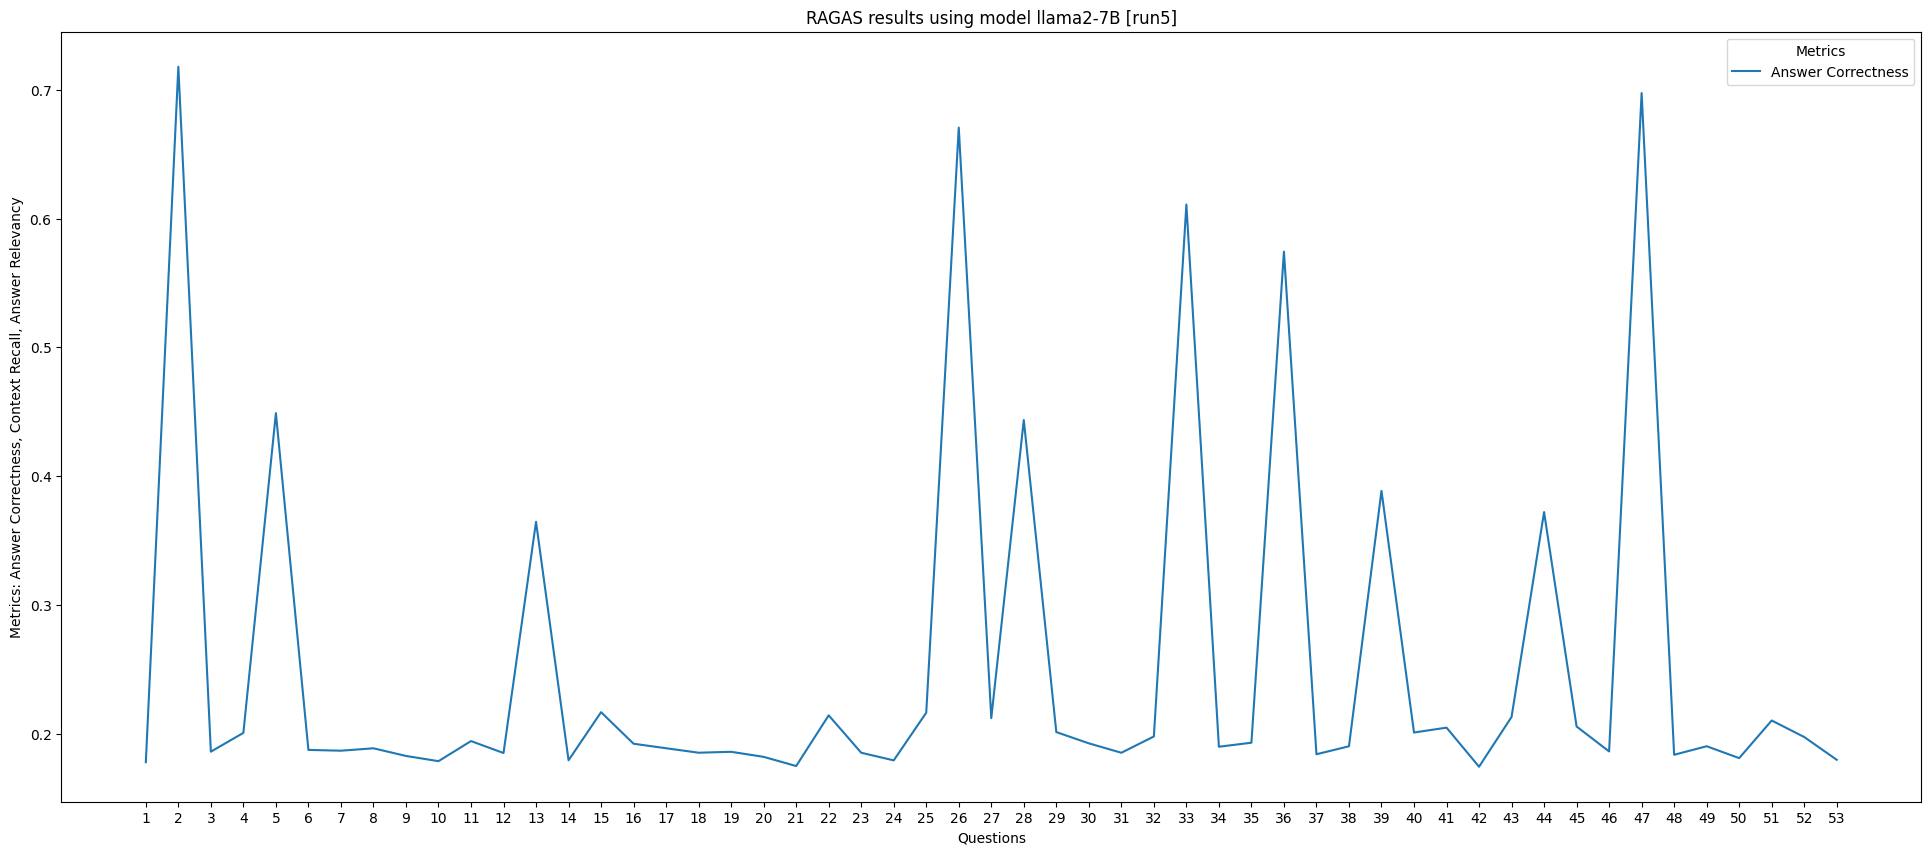

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 10))  # Width = 24 inches, Height = 10 inches
ax = plt.gca()

# Plot each metric
sb.lineplot(x=range(1, 54), y=score["answer_correctness"], ax=ax, label='Answer Correctness')
#sb.lineplot(x=range(1, 54), y=score["answer_relevancy"], ax=ax, label='Answer Relevancy',color='green')

# Customize the plot
ax.set_xticks(range(1, 54))
ax.set_xlabel('Questions')
ax.set_ylabel('Metrics: Answer Correctness, Context Recall, Answer Relevancy')
ax.set_title("RAGAS results using model llama2-7B [run5]")
ax.legend(title='Metrics')

plt.savefig('/content/drive/MyDrive/CS4371/Talos Results/Run5/scoreRun5.png', dpi=300)

#plt.savefig('/content/drive/MyDrive/CS4371/Experimental Runs/scoreRun1_AC.png', dpi=300)
#plt.savefig('/content/drive/MyDrive/CS4371/Experimental Runs/scoreRun1_AR.png', dpi=300)

plt.show()

In [ ]:
# Save the score into a .csv file
score.to_csv('/content/drive/MyDrive/CS4371/Talos Results/Run5/scoreRun5.csv', index=False)